In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import re

import warnings
warnings.filterwarnings("ignore")

In [4]:
train_setting = "wd=0.0_lr=5e-5"

In [9]:
def extract_from_profile(profile_data):
    try:
        # Extract time breakdown components
        projection_time = profile_data.get('projection', 0)
        forward_time = profile_data.get('forward', 0)
        backward_time = profile_data.get('backward', 0)
        precondition_time = profile_data.get('precondition', 0)

        # Calculate total time by summing all components
        total_time = projection_time + forward_time + backward_time + precondition_time

        # Convert seconds to minutes and return all components
        return {
            'forward': forward_time/60,
            'backward': backward_time/60,
            'projection': projection_time/60,
            'precondition': precondition_time/60,
            'total': total_time/60
        }
    except:
        return {
            'projection': 0,
            'forward': 0,
            'backward': 0,
            'precondition': 0,
            'total': 0
        }

def visualize_comprehensive_results(train_setting, projection, proj_factorize=True, variable="threshold"):
    results, time_components, labels, bar_colors, alphas = [], [], [], [], []

    colors = {
        'GC/IF-RAW/Linear': '#2ca02c',
        # 'GC/IF-RAW/LayerNorm': '#ff7f0e',
        # 'GC/IF-RAW/Linear_LayerNorm': '#d62728',
        'LoGra/IF-RAW/Linear': '#9467bd',
    }
    component_colors = {
        'forward': '#d09eee',
        'backward': '#533d61',
        'projection': '#cccccc',
        'precondition': '#ff85c4',
    }

    if variable == "threshold":
        if proj_factorize:
            projections = [f'{projection}-16*16', f'{projection}-32*32', f'{projection}-64*64']
        else:
            projections = [f'{projection}-256', f'{projection}-1024', f'{projection}-4096', f'{projection}-6000']
        methods = {
            'GC/IF-RAW/Linear': {
                'projections': projections,
                'thrd': [0.0, 0.00001, 0.0001],
                'pattern': lambda p, t: f"GC/IF-RAW/Linear/{p}_thrd-{t}_rdp-0.0.pt"
            },
            # 'GC/IF-RAW/LayerNorm': {
            #     'projections': projections,
            #     'thrd': [0.0, 0.00001, 0.0001, 0.001],
            #     'pattern': lambda p, t: f"GC/IF-RAW/LayerNorm/{p}_thrd-{t}_rdp-0.0.pt"
            # },
            # 'GC/IF-RAW/Linear_LayerNorm': {
            #     'projections': projections,
            #     'thrd': [0.0, 0.00001, 0.0001, 0.001],
            #     'pattern': lambda p, t: f"GC/IF-RAW/Linear_LayerNorm/{p}_thrd-{t}_rdp-0.0.pt"
            # },
            'LoGra/IF-RAW/Linear': {
                'projections': [f'Random-16*16', f'Random-32*32', f'Random-64*64'],
                'thrd': [0.0],
                'pattern': lambda p, t: f"LoGra/IF-RAW/Linear/{p}_thrd-{t}_rdp-0.0.pt"
            },
        }
        alpha_map = {0.0: 1.0, 0.00001: 0.8, 0.0001: 0.6, 0.001: 0.4}

    elif variable == "random_drop":
        if projection == "Identity":
            projections = [f'{projection}-64*64']
            methods = {
                'GC/IF-RAW/Linear': {
                    'projections': projections,
                    'rdp': [0.93, 0.95, 0.97, 0.99],
                    'pattern': lambda p, t: f"GC/IF-RAW/Linear/{p}_thrd-0.0_rdp-{t}.pt"
                },
                # 'GC/IF-RAW/LayerNorm': {
                #     'projections': projections,
                #     'rdp': [0.0, 0.2, 0.4, 0.6, 0.8],
                #     'pattern': lambda p, t: f"GC/IF-RAW/LayerNorm/{p}_thrd-0.0_rdp-{t}.pt"
                # },
                # 'GC/IF-RAW/Linear_LayerNorm': {
                #     'projections': projections,
                #     'rdp': [0.0, 0.2, 0.4, 0.6, 0.8],
                #     'pattern': lambda p, t: f"GC/IF-RAW/Linear_LayerNorm/{p}_thrd-0.0_rdp-{t}.pt"
                # },
                'LoGra/IF-RAW/Linear': {
                    'projections': [f'Random-16*16', f'Random-32*32', f'Random-64*64'],
                    'rdp': [0.0],
                    'pattern': lambda p, t: f"LoGra/IF-RAW/Linear/{p}_thrd-0.0_rdp-{t}.pt"
                },
            }
            alpha_map = {0.0: 1.0, 0.93: 0.8, 0.95: 0.6, 0.97: 0.4, 0.99: 0.2}
        else:
            if proj_factorize:
                projections = [f'{projection}-16*16', f'{projection}-32*32', f'{projection}-64*64']
            else:
                projections = [f'{projection}-256', f'{projection}-1024', f'{projection}-4096']
            methods = {
                'GC/IF-RAW/Linear': {
                    'projections': projections,
                    'rdp': [0.0, 0.2, 0.4, 0.6, 0.8],
                    'pattern': lambda p, t: f"GC/IF-RAW/Linear/{p}_thrd-0.0_rdp-{t}.pt"
                },
                # 'GC/IF-RAW/LayerNorm': {
                #     'projections': projections,
                #     'rdp': [0.0, 0.2, 0.4, 0.6, 0.8],
                #     'pattern': lambda p, t: f"GC/IF-RAW/LayerNorm/{p}_thrd-0.0_rdp-{t}.pt"
                # },
                # 'GC/IF-RAW/Linear_LayerNorm': {
                #     'projections': projections,
                #     'rdp': [0.0, 0.2, 0.4, 0.6, 0.8],
                #     'pattern': lambda p, t: f"GC/IF-RAW/Linear_LayerNorm/{p}_thrd-0.0_rdp-{t}.pt"
                # },
                'LoGra/IF-RAW/Linear': {
                    'projections': [f'Random-16*16', f'Random-32*32', f'Random-64*64'],
                    'rdp': [0.0],
                    'pattern': lambda p, t: f"LoGra/IF-RAW/Linear/{p}_thrd-0.0_rdp-{t}.pt"
                },
            }
            alpha_map = {0.0: 1.0, 0.2: 0.8, 0.4: 0.6, 0.6: 0.4, 0.8: 0.2}
    elif variable == "localize":
        if projection == "Localize":
            projections = [f'{projection}']
            methods = {
                'GC/IF-RAW/Linear': {
                    'projections': ["Localize-16*16", "Localize-32*32", "Localize-64*64"],
                    'loc': [-1],
                    'pattern': lambda p, t: f"GC/IF-RAW/Linear/{p}_thrd-0.0_rdp-0.0.pt"
                },
                # 'GC/IF-RAW/LayerNorm': {
                #     'projections': projections,
                #     'rdp': [0.0, 0.2, 0.4, 0.6, 0.8],
                #     'pattern': lambda p, t: f"GC/IF-RAW/LayerNorm/{p}_thrd-0.0_rdp-{t}.pt"
                # },
                # 'GC/IF-RAW/Linear_LayerNorm': {
                #     'projections': projections,
                #     'rdp': [0.0, 0.2, 0.4, 0.6, 0.8],
                #     'pattern': lambda p, t: f"GC/IF-RAW/Linear_LayerNorm/{p}_thrd-0.0_rdp-{t}.pt"
                # },
                'LoGra/IF-RAW/Linear': {
                    'projections': [f'Random-16*16', f'Random-32*32', f'Random-64*64'],
                    'loc': [-1],
                    'pattern': lambda p, t: f"LoGra/IF-RAW/Linear/{p}_thrd-0.0_rdp-0.0.pt"
                },
            }
            alpha_map = {-1: 1.0}

    # Collect results
    for method, config in methods.items():
        for proj in config['projections']:
            if variable == "threshold":
                config_variable = config['thrd']
            elif variable == "random_drop":
                config_variable = config['rdp']
            elif variable == "localize":
                config_variable = config['loc']

            for var in config_variable:
                pattern = config['pattern'](proj, var)
                result_all = torch.load(f"results/{train_setting}/{pattern}", map_location='cpu', weights_only=False)
                result = result_all["lds"]
                time_comp = extract_from_profile(result_all["profile"])

                if result is not None:
                    results.append(result)
                    time_components.append(time_comp)
                    labels.append(f"{proj}")
                    bar_colors.append(colors[method])
                    alphas.append(alpha_map[var])

    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10), height_ratios=[1, 1])

    # Create bars for LDS score
    bars1 = []
    for i, (value, color, alpha) in enumerate(zip(results, bar_colors, alphas)):
        bar = ax1.bar(i, value, width=0.6, color=color, alpha=alpha)
        bars1.extend(bar)

    # Create legends
    method_legend = ax1.legend(handles=[plt.Rectangle((0, 0), 1, 1, fc=color, label=method) for method, color in colors.items()],
                              title='Methods', loc='upper left', bbox_to_anchor=(0, 1))

    if variable == "threshold":
        title = 'Threshold'
    elif variable == "random_drop":
        title = 'Random Drop'
    elif variable == "localize":
        title = 'Localization'

    var_legend = ax1.legend(handles=[plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=alpha, label=f'{var_val}') for var_val, alpha in alpha_map.items()],
                                 title=title, loc='upper left', bbox_to_anchor=(0, 0.65))

    # Add both legends
    ax1.add_artist(method_legend)
    ax1.add_artist(var_legend)

    ax1.set_ylabel('LDS Score', fontsize=12)
    ax1.set_title('Result', fontsize=14)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Order of components from bottom to top
    components = ['forward', 'backward', 'projection', 'precondition']

    # Create one bar per component for each data point
    for idx in range(len(time_components)):
        bottom_val = 0
        for component in components:
            # For each experiment, add one segment for each component
            component_value = time_components[idx][component]
            ax2.bar(idx, component_value, bottom=bottom_val, width=0.6,
                   color=component_colors[component], alpha=alphas[idx] * 0.8 + 0.2)
            bottom_val += component_value

    # Add component legend separately
    component_patches = [plt.Rectangle((0,0), 1, 1, color=component_colors[comp], label=comp) for comp in components]
    ax2.legend(handles=component_patches, title='Components', loc='upper left', bbox_to_anchor=(0, 1))

    ax2.set_ylabel('Runtime (minutes)', fontsize=12)
    ax2.set_title('Runtime Breakdown', fontsize=14)
    ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        if height is not None:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}', ha='center', va='bottom')

    # Add total time label on top of each stacked bar
    for i, comp in enumerate(time_components):
        total_height = comp['total']
        ax2.text(i, total_height, f'{total_height:.1f}', ha='center', va='bottom')

    # Set x-axis labels
    for ax in [ax1, ax2]:
        ax.set_xticks(np.arange(len(results)))
        ax.set_xticklabels(labels, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

## Threshold

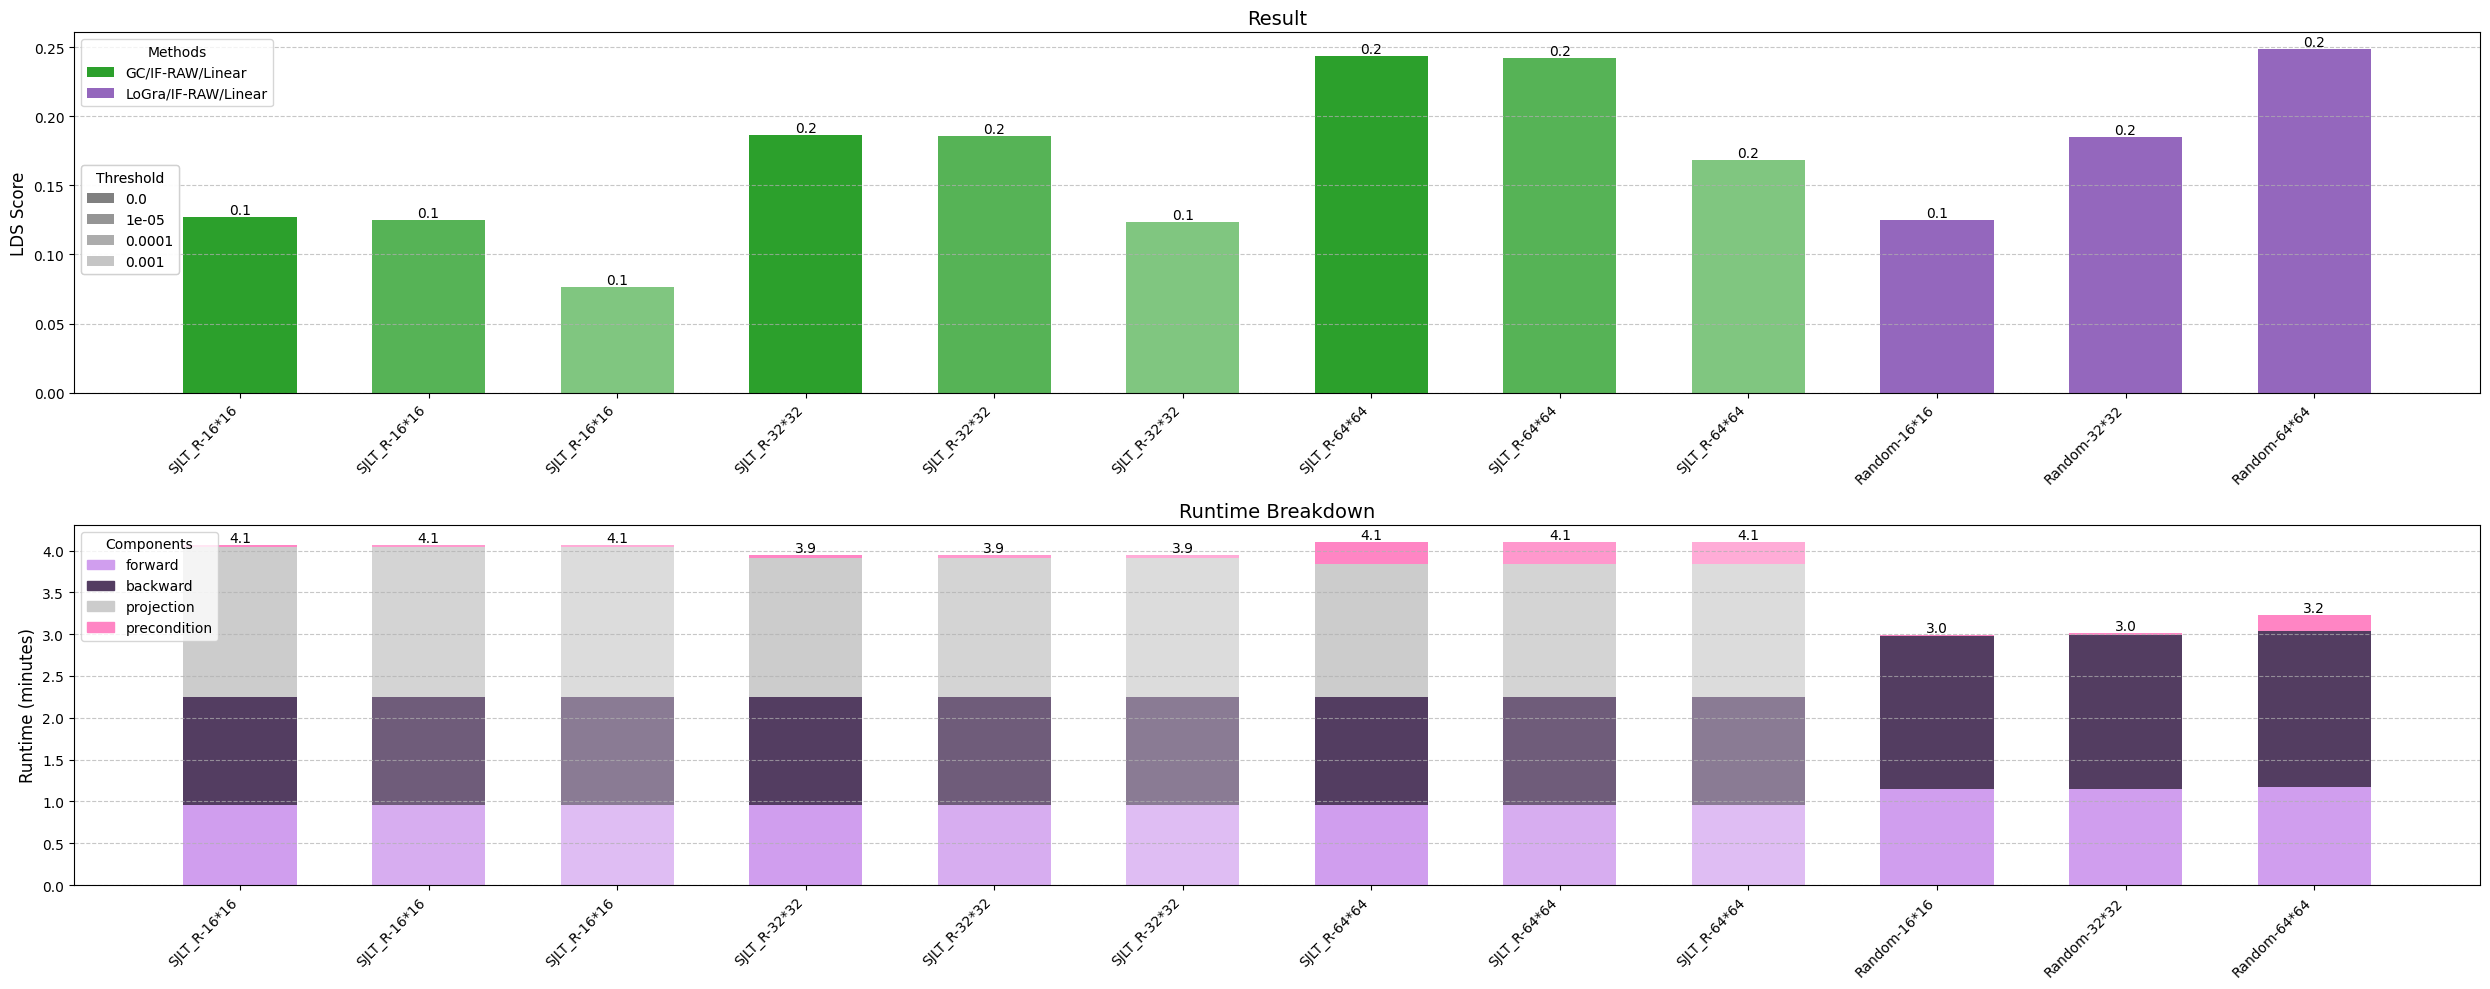

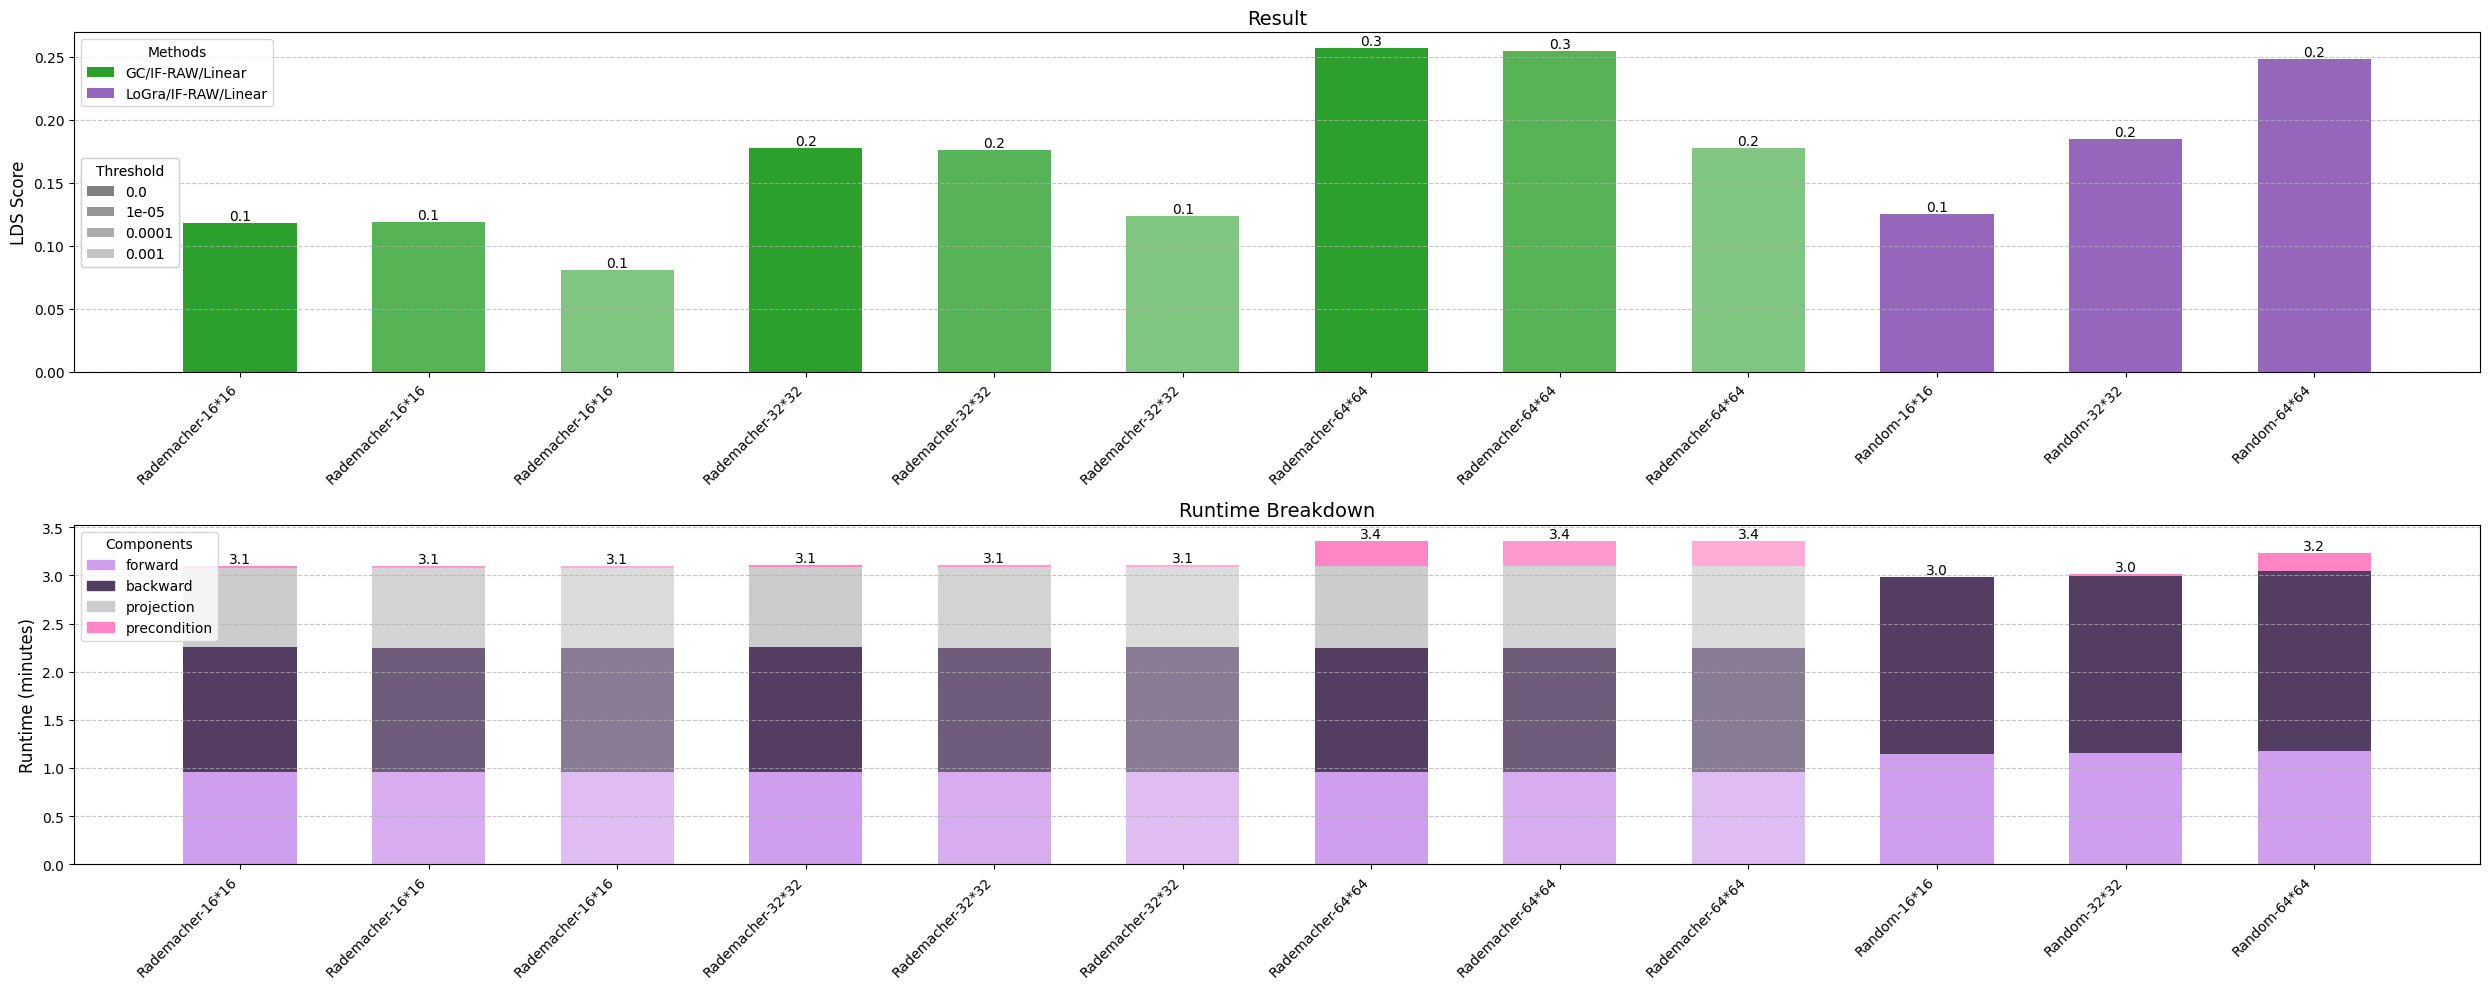

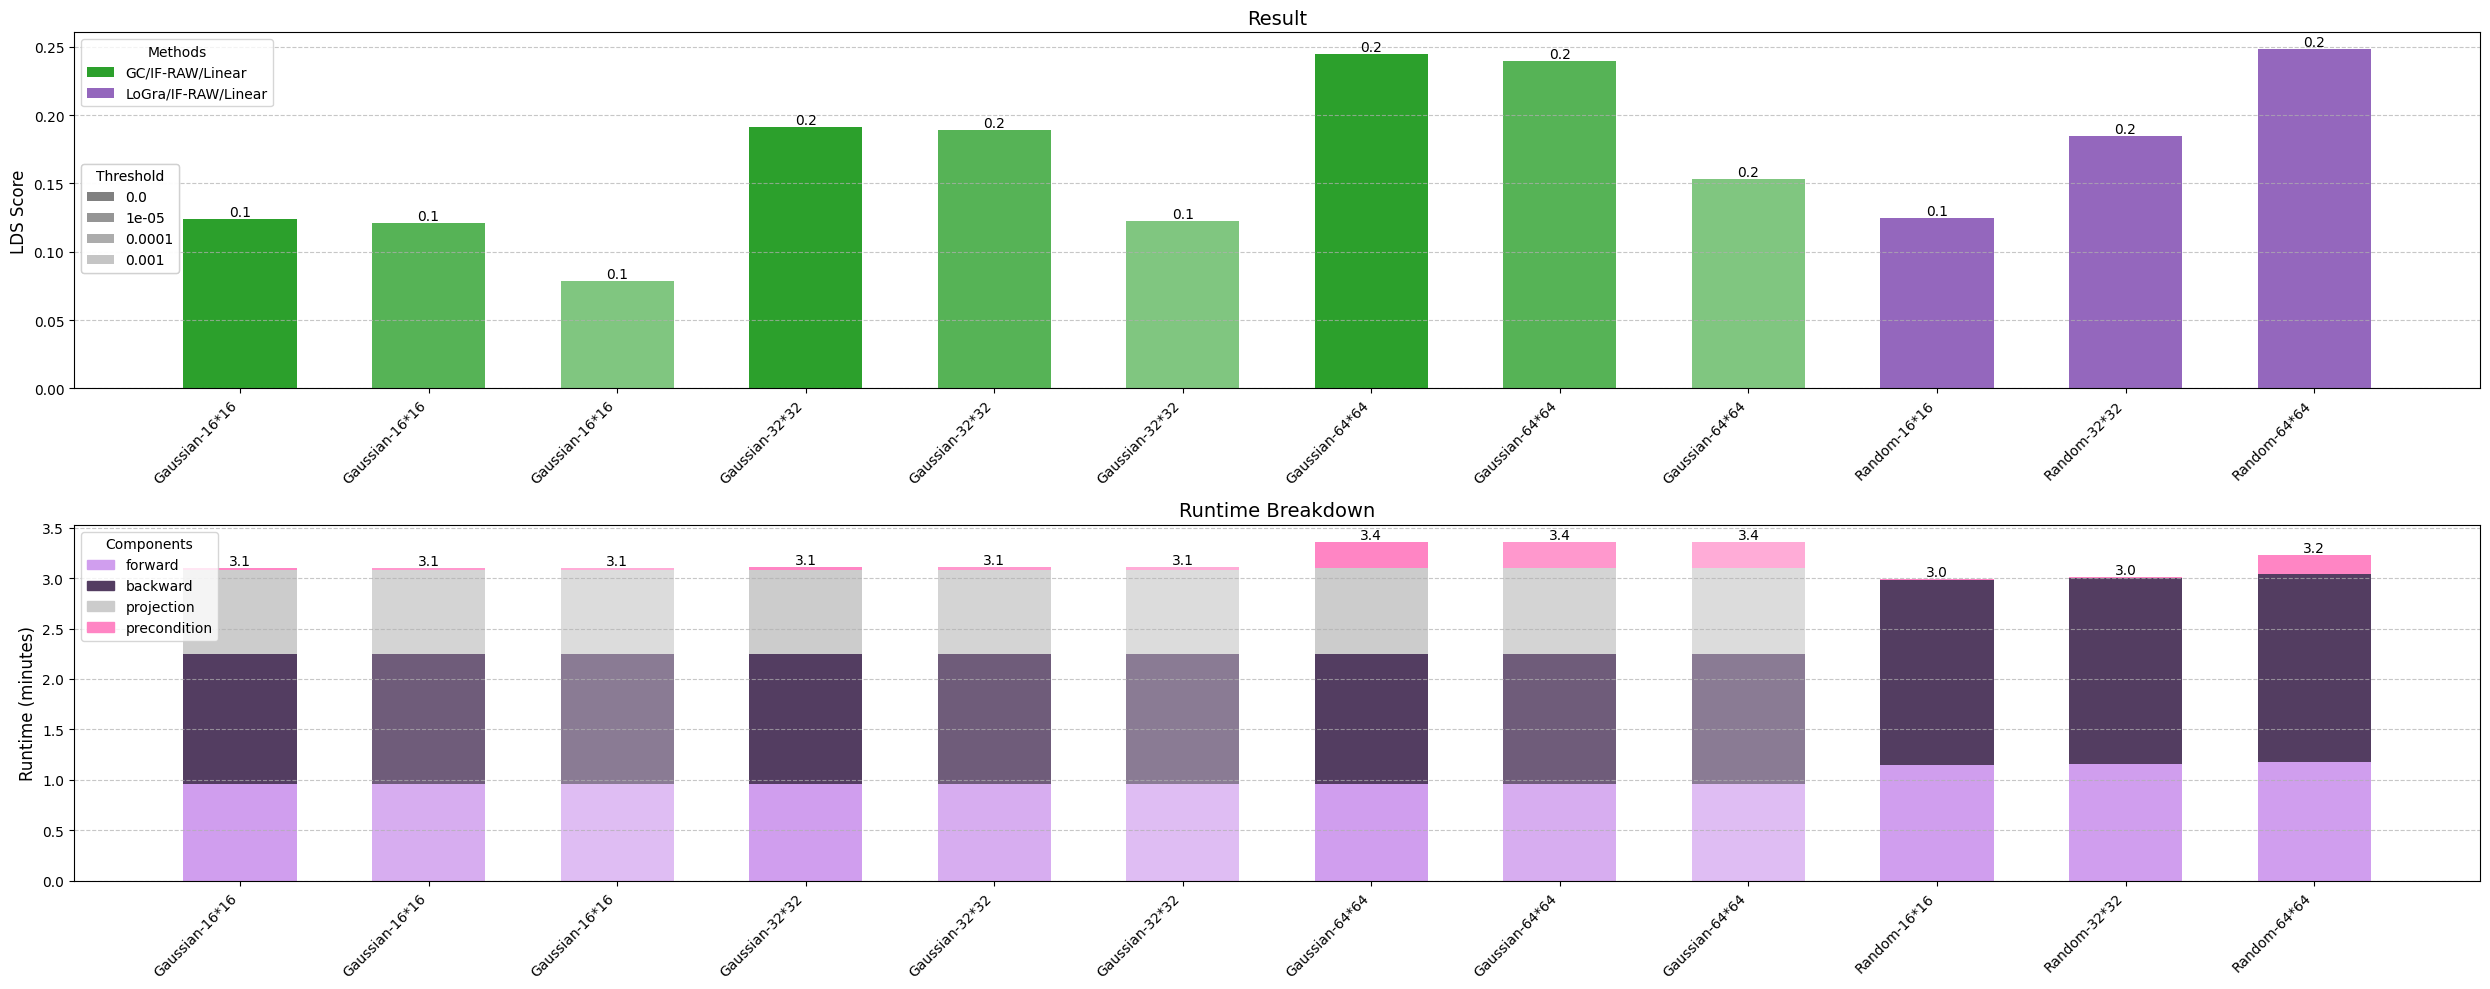

In [4]:
visualize_comprehensive_results(train_setting, projection="SJLT_R", variable="threshold", proj_factorize=True)
visualize_comprehensive_results(train_setting, projection="Rademacher", variable="threshold", proj_factorize=True)
visualize_comprehensive_results(train_setting, projection="Gaussian", variable="threshold", proj_factorize=True)

In [5]:
# visualize_comprehensive_results(train_setting, projection="SJLT", variable="threshold", proj_factorize=False)
# visualize_comprehensive_results(train_setting, projection="Rademacher", variable="threshold", proj_factorize=False)
# visualize_comprehensive_results(train_setting, projection="Gaussian", variable="threshold", proj_factorize=False)

## Random Drop

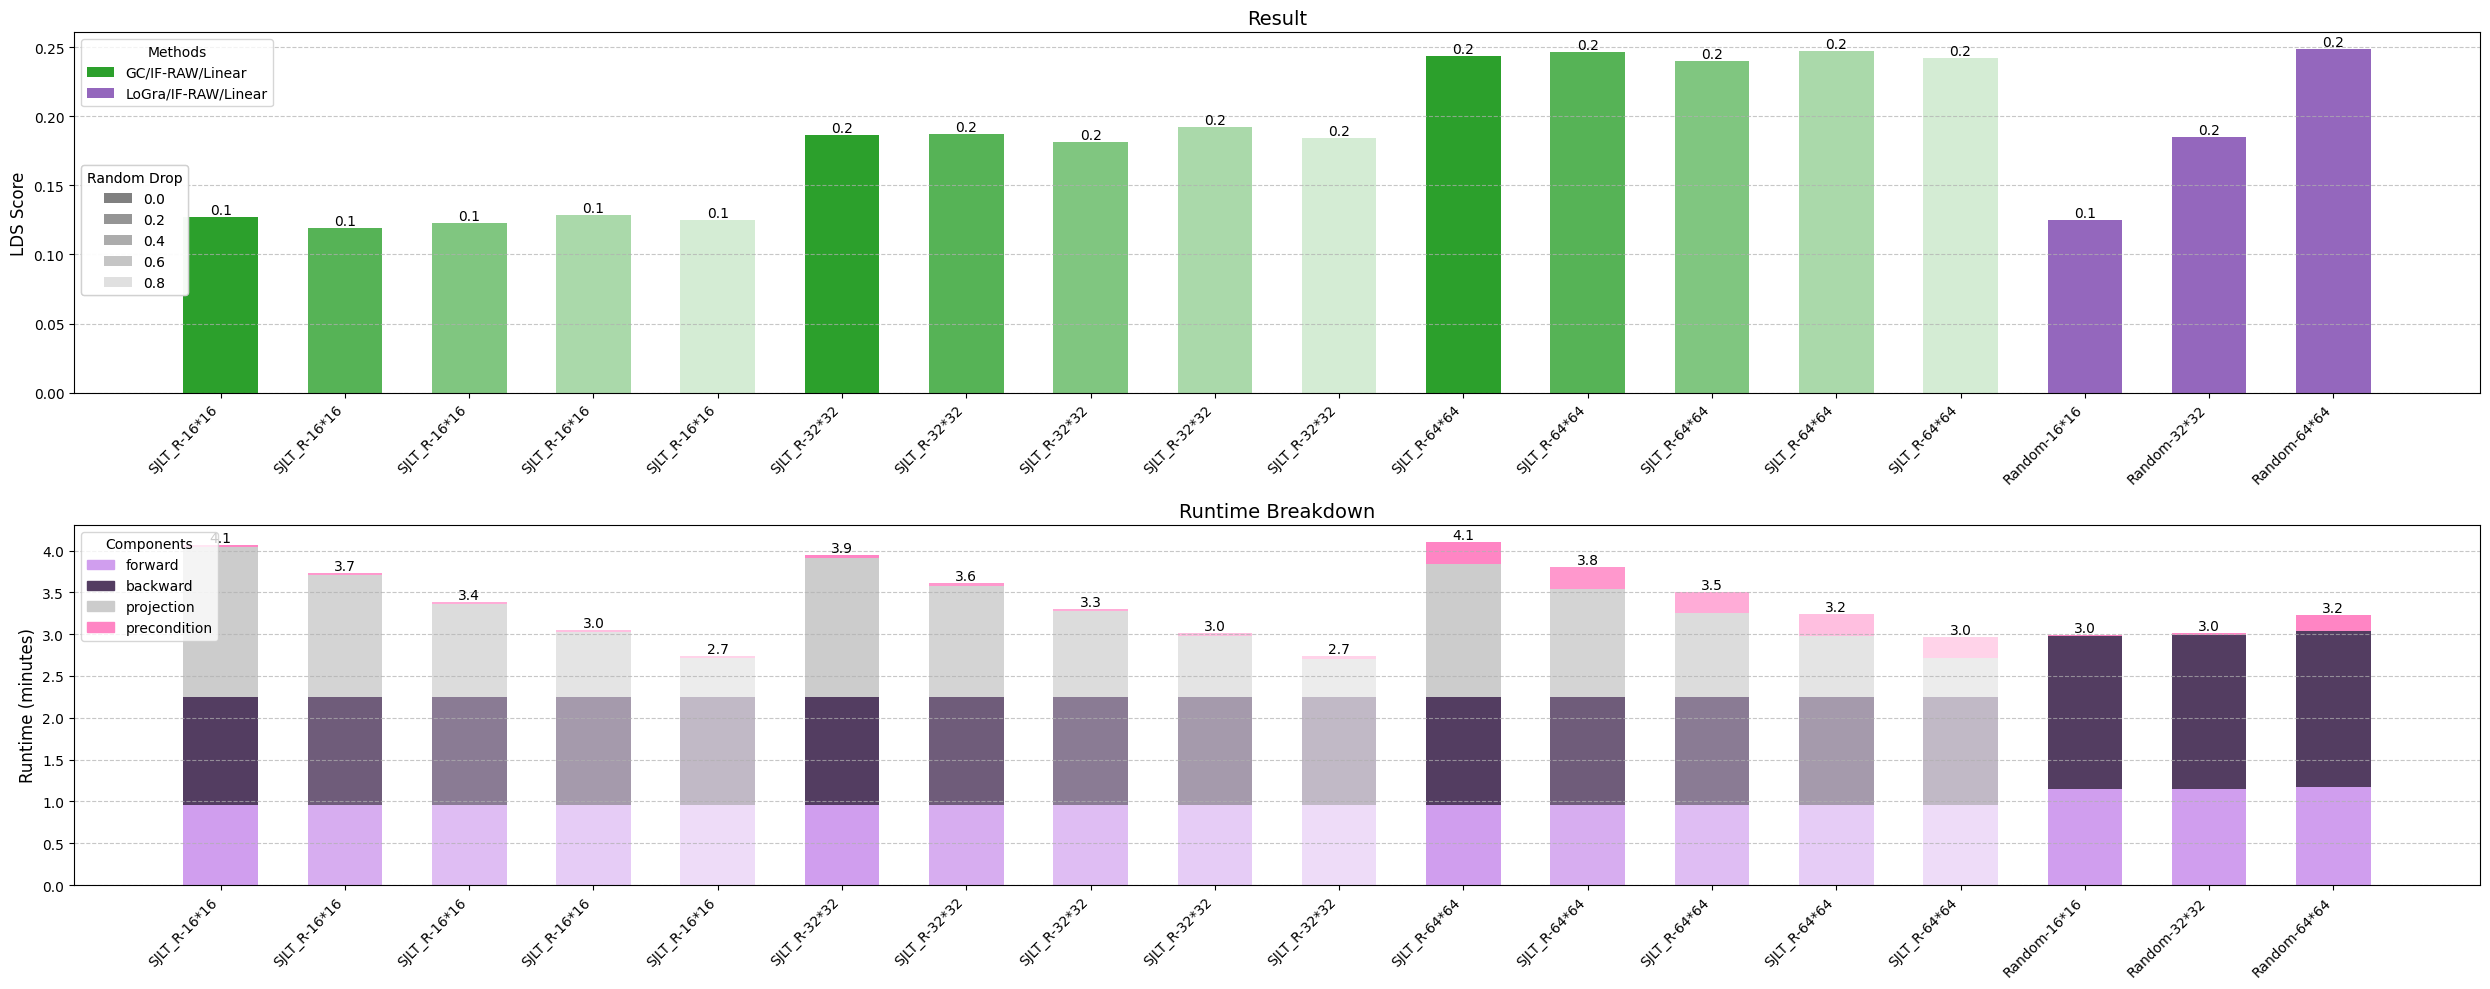

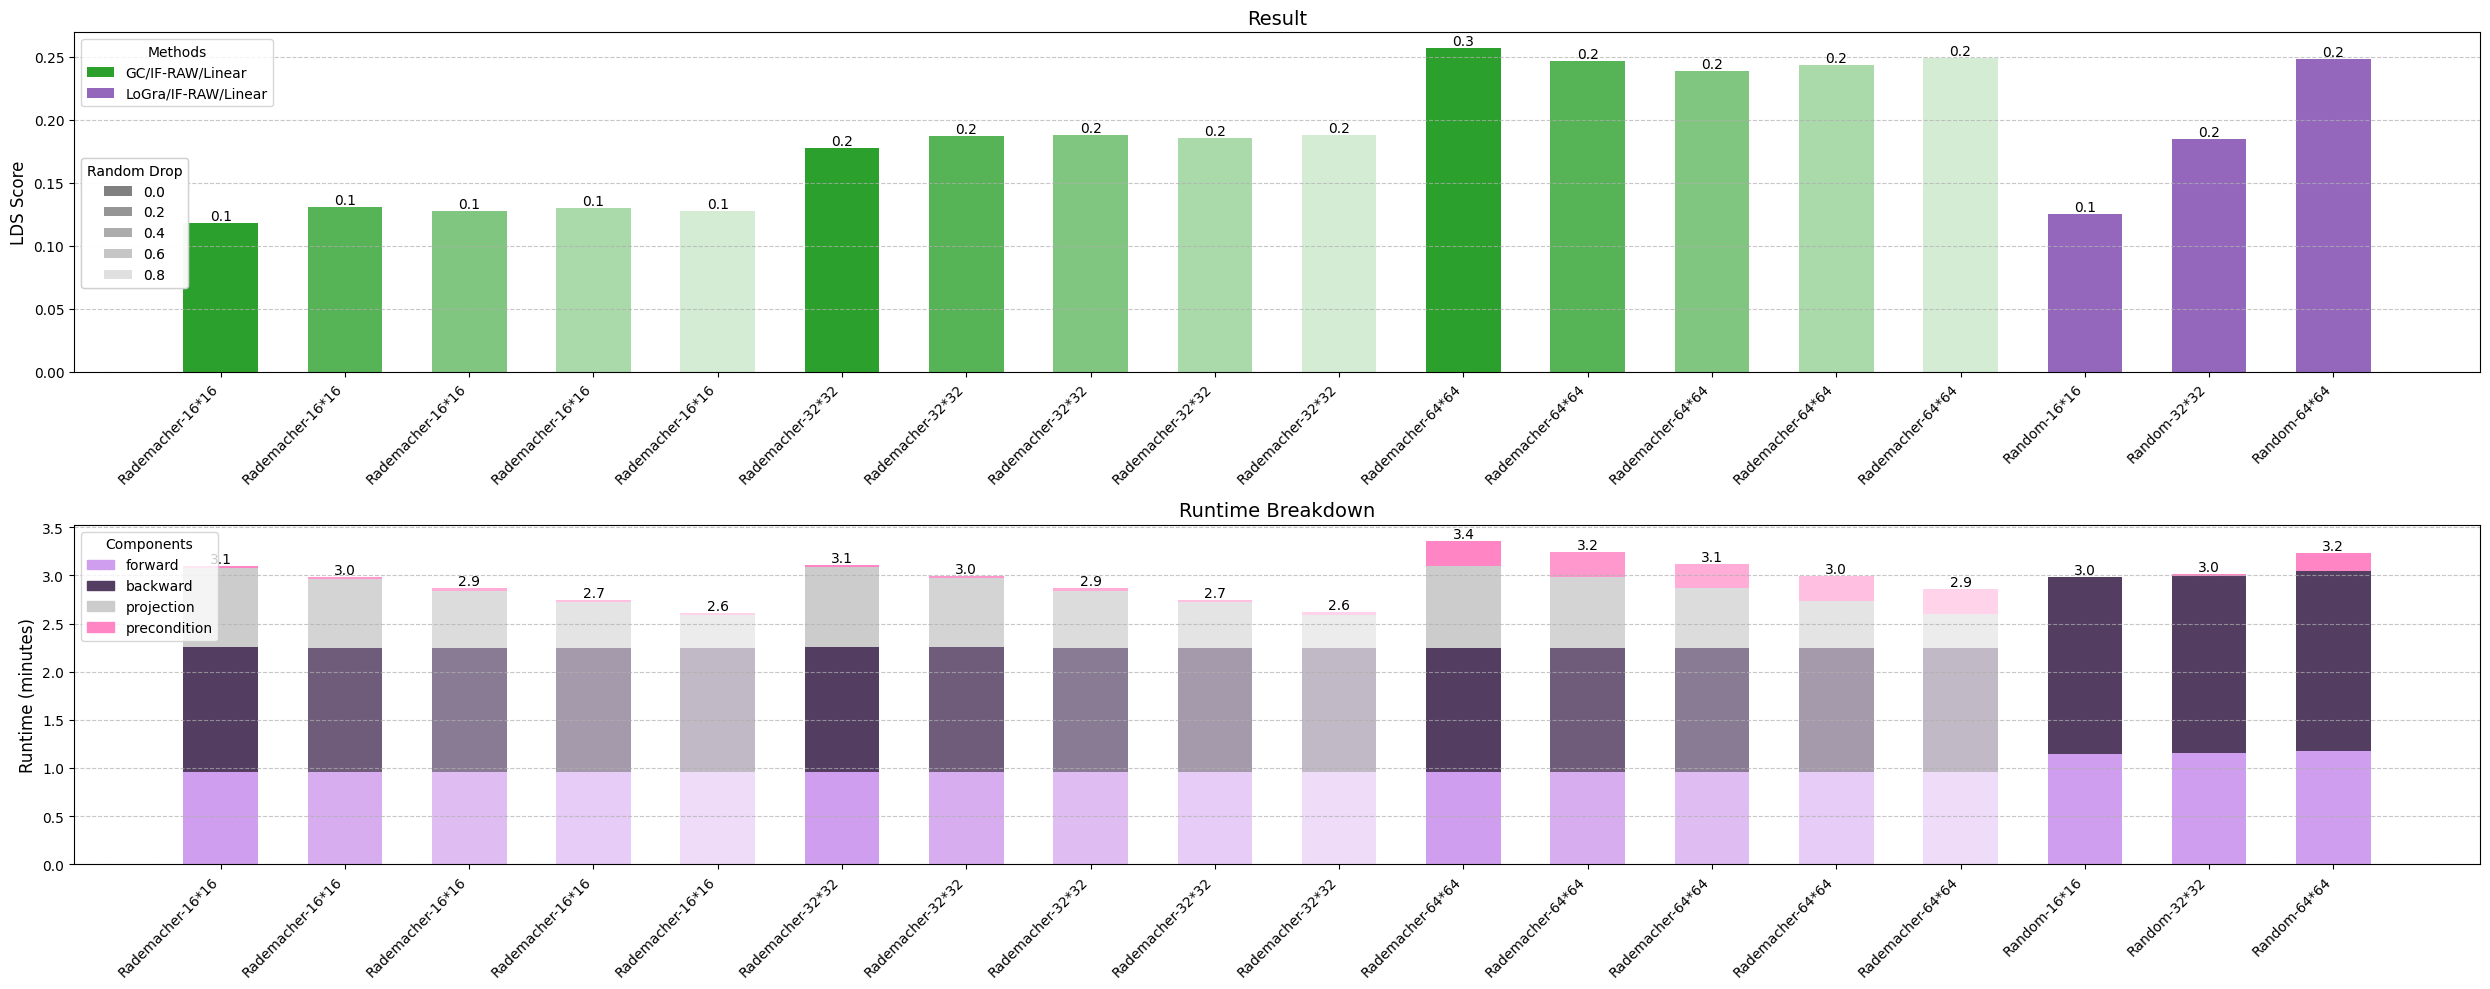

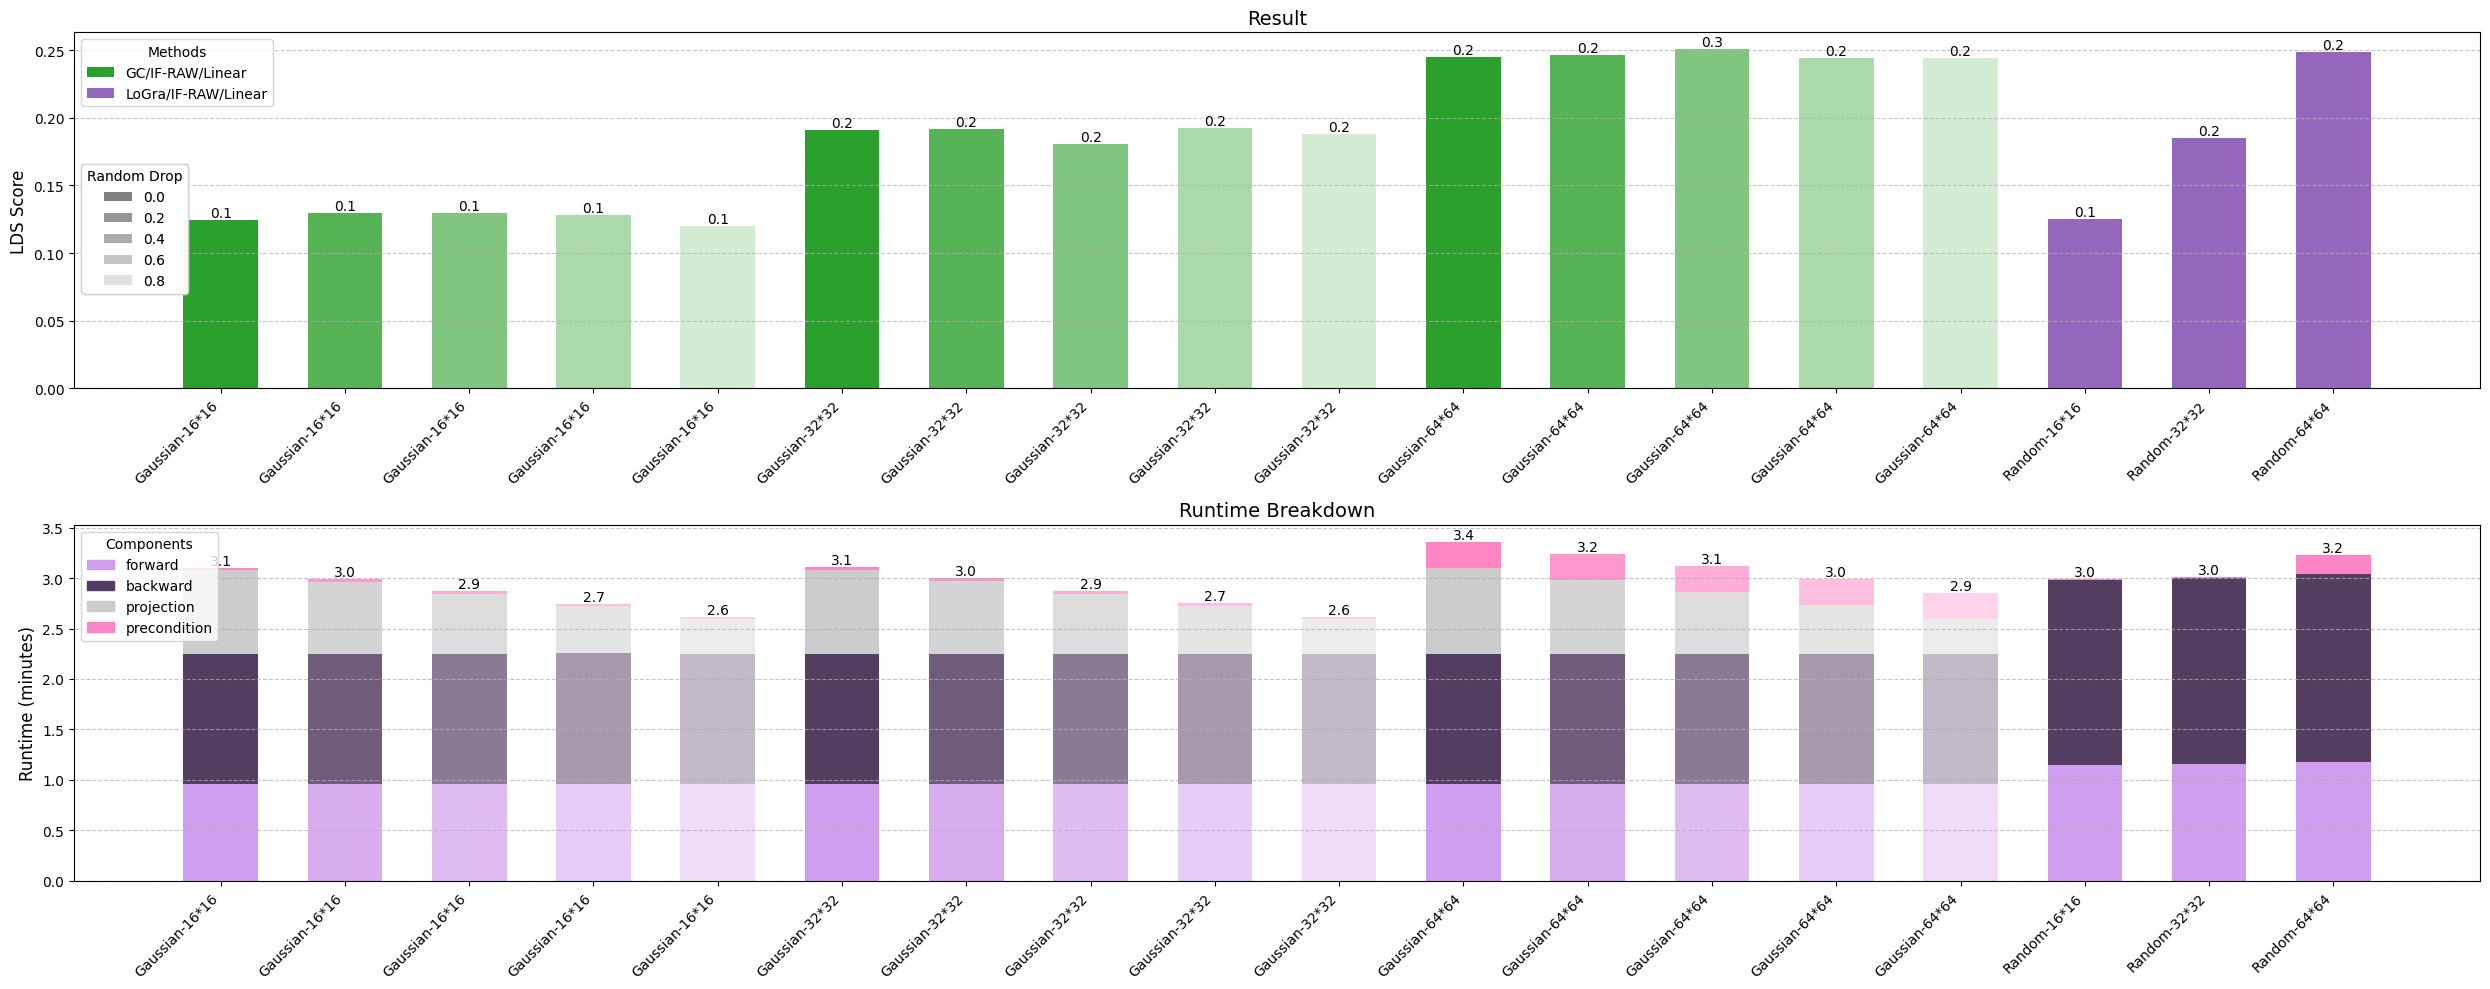

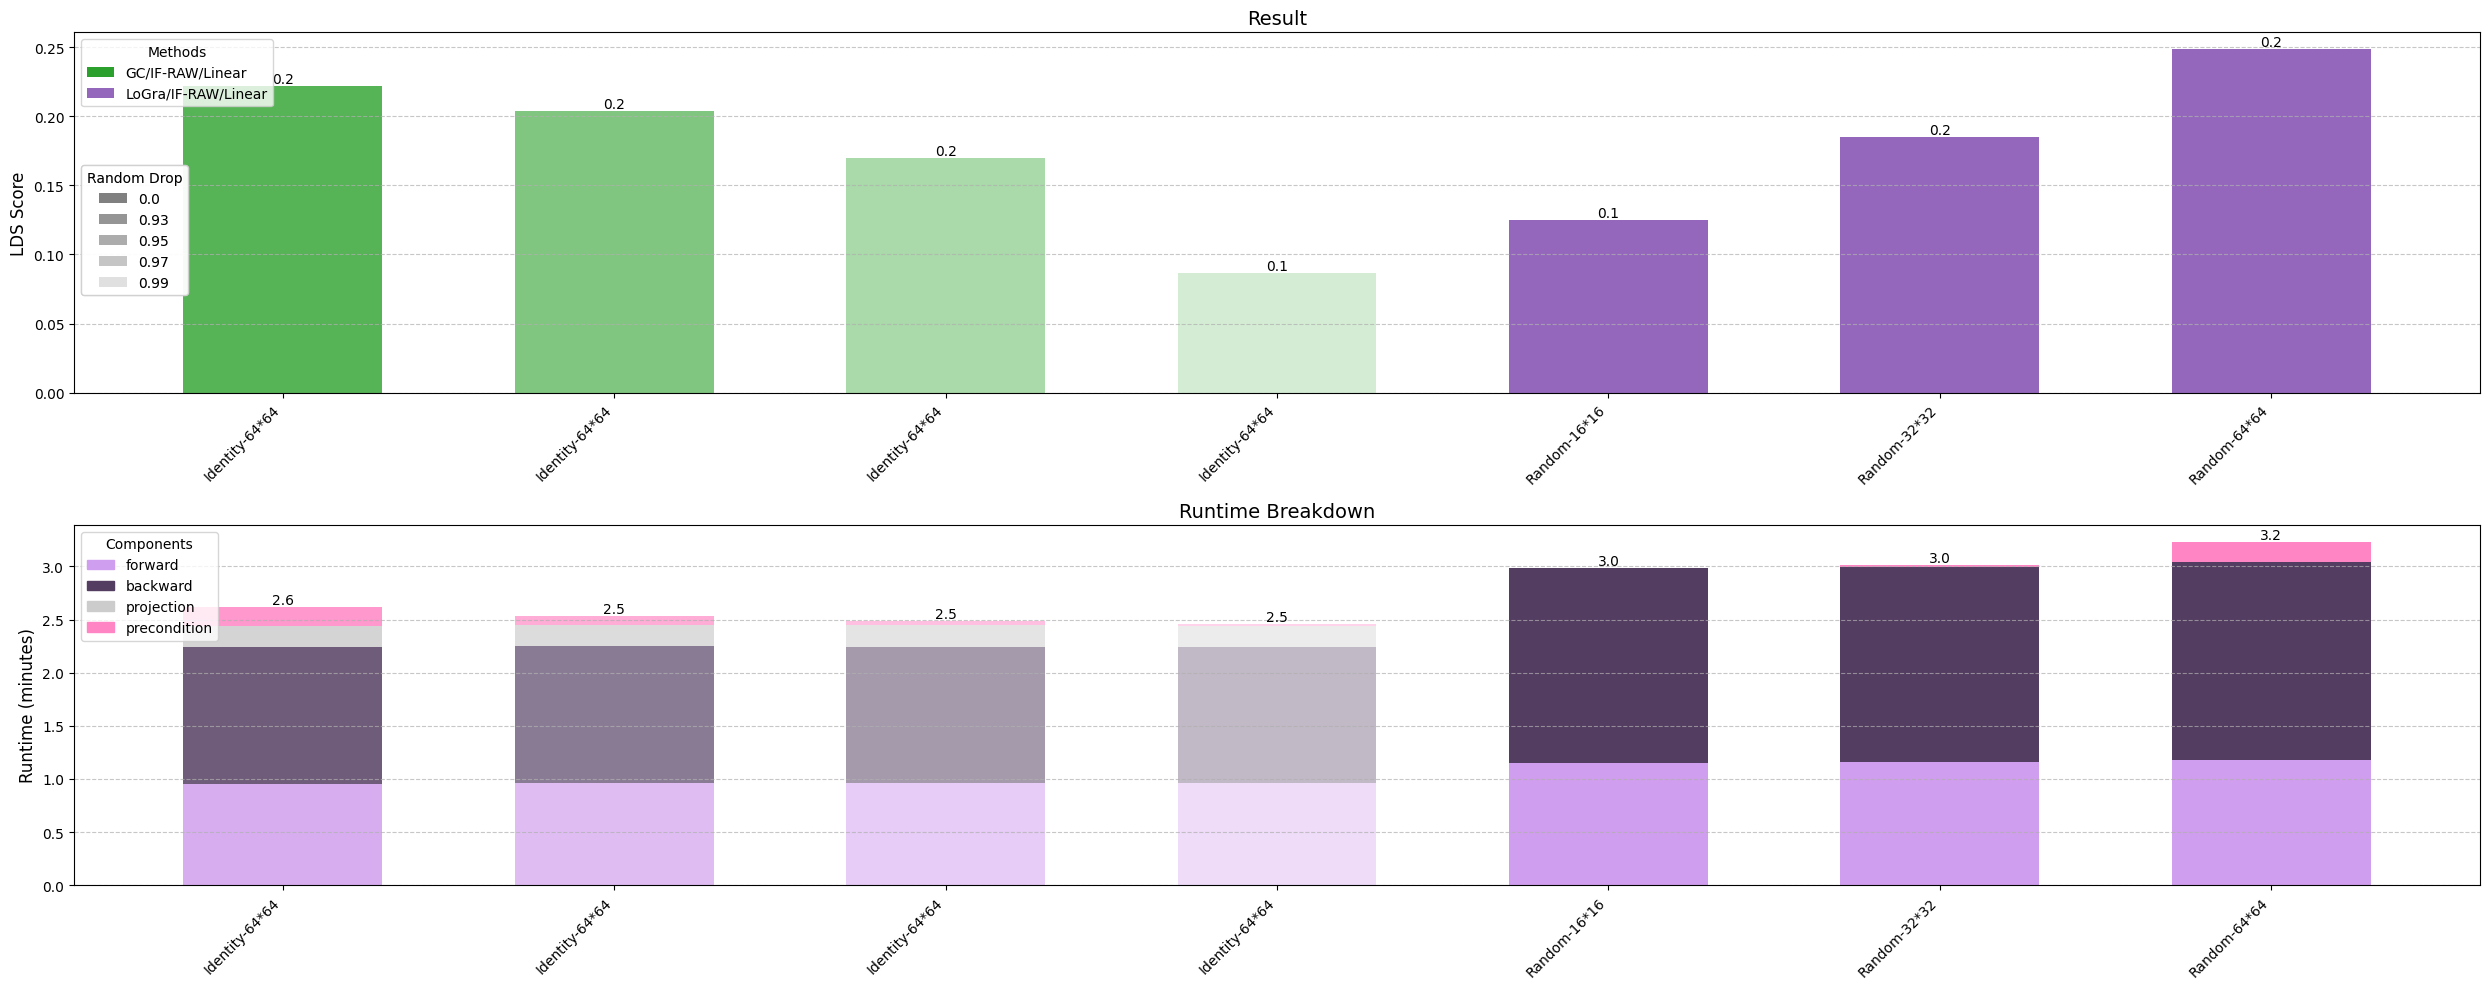

In [6]:
visualize_comprehensive_results(train_setting, projection="SJLT_R", variable="random_drop", proj_factorize=True)
visualize_comprehensive_results(train_setting, projection="Rademacher", variable="random_drop", proj_factorize=True)
visualize_comprehensive_results(train_setting, projection="Gaussian", variable="random_drop", proj_factorize=True)
visualize_comprehensive_results(train_setting, projection="Identity", variable="random_drop", proj_factorize=True)

In [7]:
# visualize_comprehensive_results(train_setting, projection="SJLT_R", variable="random_drop", proj_factorize=False)
# visualize_comprehensive_results(train_setting, projection="Rademacher", variable="random_drop", proj_factorize=False)
# visualize_comprehensive_results(train_setting, projection="Gaussian", variable="random_drop", proj_factorize=False)

# Localize

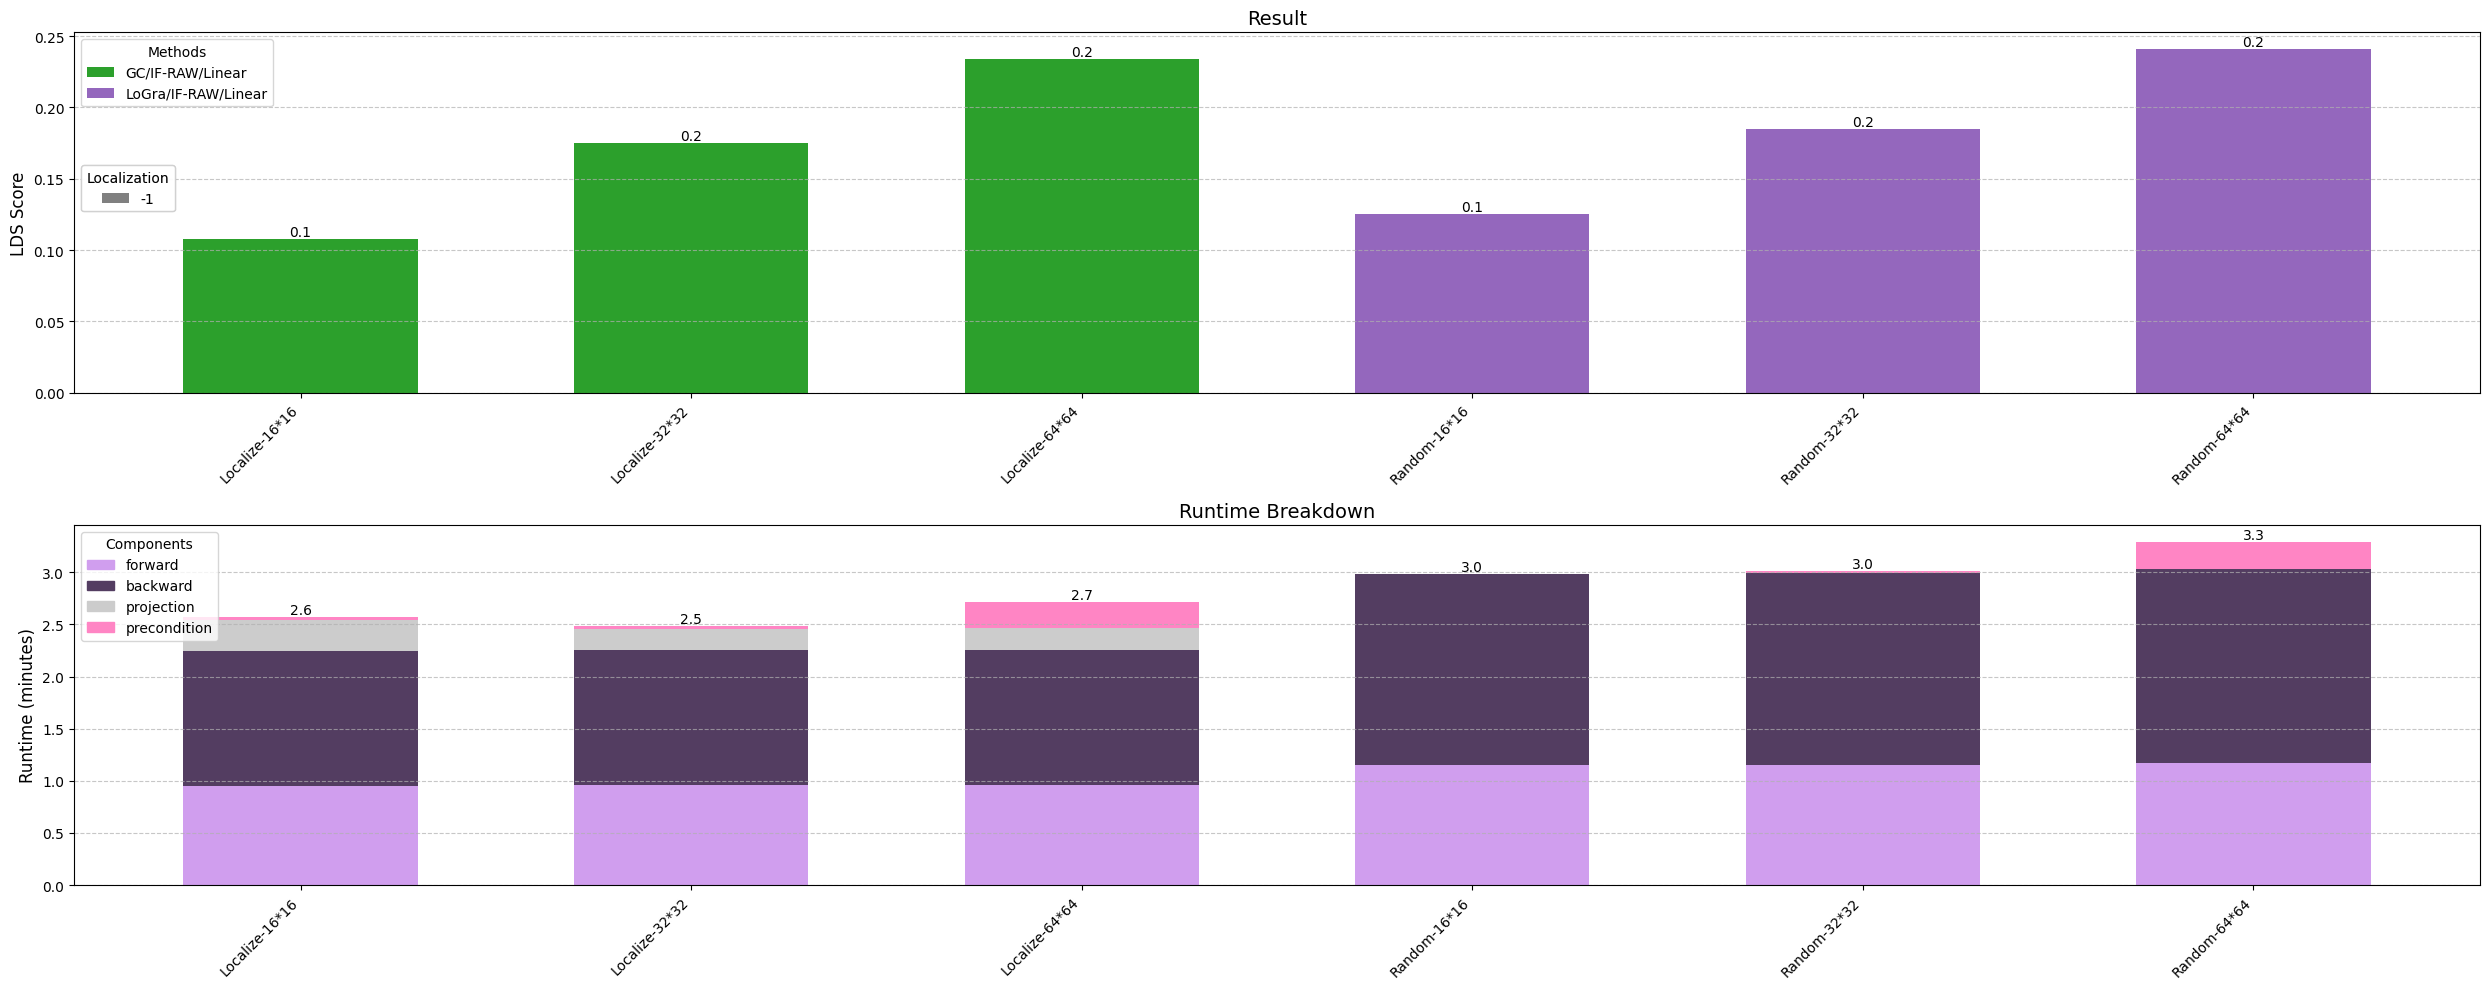

In [14]:
visualize_comprehensive_results(train_setting, projection="Localize", variable="localize")